# Серия экспериментов с разными наборами признаков для объединенного датасета

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
from pydantic import ValidationError
from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_DIR, RAW_DIR
from olist_churn_prediction.schemas_interim import MergedDfSchemaInterim
from olist_churn_prediction import feature_processing
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import category_encoders as ce

In [113]:
pd.set_option('display.max_columns', None)

In [114]:
df = pd.read_parquet(INTERIM_DIR / "merged_churn_interim.parquet")

for i, row in df.head(5).iterrows():
    try:
        MergedDfSchemaInterim.model_validate(row.to_dict())
    except ValidationError as e:
        print(f"\nRow {i}:\n{e}\n")


Row 0:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 1:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 2:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 3:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 4:
1 validation error for MergedDfSchemaInterim
churned
  E

In [115]:
df = feature_processing.load_data(INTERIM_DIR / "merged_churn_interim.parquet",
                      schema = MergedDfSchemaInterim,
                      validate = False)

In [116]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93882 entries, 0 to 93881
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93882 non-null  string        
 1   order_products_value           93882 non-null  float32       
 2   order_freight_value            93882 non-null  float32       
 3   order_items_qty                93882 non-null  Int64         
 4   product_photos_qty             93882 non-null  Int64         
 5   product_name_lenght            93882 non-null  Float64       
 6   product_description_lenght     93882 non-null  Float64       
 7   review_creation_date           93882 non-null  datetime64[ns]
 8   review_answer_timestamp        93882 non-null  datetime64[ns]
 9   order_purchase_timestamp       93882 non-null  datetime64[ns]
 10  order_aproved_at               93882 non-null  datetime64[ns]
 11  order_estimated

None

In [117]:
df = df.rename(columns={'value': 'summary_payments_value'})

In [118]:
display(df.head())

,order_id,order_products_value,order_freight_value,order_items_qty,product_photos_qty,product_name_lenght,product_description_lenght,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_city,customer_state,customer_zip_code_prefix,product_id,review_id,review_score,product_category_name_english,summary_payments_value,installments,sequential,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,seller_id,seller_zip_code_prefix,seller_city,seller_state,churned
0,0000f01da58c553799200eb71eb0563b,54.900002,18.000000,1,3,58.0,1146.0,2018-01-17,2018-01-18 11:25:59,2017-12-20 16:02:06,2017-12-22 02:38:38.513998,2018-01-16,2018-01-16 22:28:47.059813,aaf96a43700cc28f3d1f6115e9bf311e,sao_jose_dos_campos,sp,122,d363e421b1d15376b299089946fed127,0000f01da58c553799200eb71eb0563b,3,furniture_living_room,72.900002,1,1,3200.0,30.0,11.0,30.0,366d0f35dec4298dce6b76abb9b214ec,870d0118f7a9d85960f29ad89d5d989a,377,pocos_de_caldas,mg,1
1,00010242fe8c5a6d1ba2dd792cb16214,58.900002,13.290000,1,4,58.0,627.0,2017-09-21,2017-09-22 13:57:03,2017-09-13 08:59:02,2017-09-13 09:45:35.019805,2017-09-29,2017-09-20 23:43:48.274761,3ce436f183e68e07877b285a838db11a,campos_dos_goytacazes,rj,280,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,5,cool_stuff,72.190002,2,1,550.0,25.0,7.0,11.0,d71416e1848ae3efa978c0bea9704733,48436dade18ac8b2bce089ec2a041202,272,volta_redonda_1,sp,1
2,00026c8a4fe2c14efa2afe807921981c,389.980011,87.300003,2,4,47.0,417.0,2018-08-05,2018-08-05 15:07:49,2018-07-20 04:39:11,2018-07-21 03:15:19.821915,2018-08-20,2018-08-04 00:16:50.549625,a7785a0278913274fddadfb4010eb59e,lagoa_grande_1,pe,563,9bf49e13f79afe62919c79d125d81cf8,00026c8a4fe2c14efa2afe807921981c,5,garden_tools,477.279999,1,1,1150.0,22.0,21.0,16.0,ee54aa475334c71b07ab5a1055699f38,dfc5fb7259bb2b599ca565e6e9448f0f,097,sao_bernardo_do_campo,sp,0
3,000312d02b605a8a630c3a9882793ffb,600.000000,73.199997,4,10,60.0,1632.0,2017-09-30,2017-10-03 01:41:10,2017-09-19 12:16:14,2017-09-19 12:30:10.302973,2017-10-10,2017-09-29 19:12:27.606354,d54487c6cb43a7ae702eac4adc1d9224,piuma,es,292,588ea3decc0d8e1d19ce6160c5b0da1b,000312d02b605a8a630c3a9882793ffb,5,housewares,673.200012,10,1,1350.0,43.0,18.0,18.0,fb7ac054945d4ead94959436e74aadca,955fee9216a65b617aa5c0531780ce60,047,sao_paulo,sp,1
4,000330af600103828257923c9aa98ae2,59.489998,33.700001,2,7,49.0,1429.0,2017-12-10,2017-12-15 02:58:44,2017-11-13 22:59:54,2017-11-13 23:10:40.663223,2017-12-13,2017-12-09 16:42:14.232409,fad0bbc7d520cbb3c5b67d4d4b546826,barra_de_sao_joao,rj,288,8dacd980e54f23aaaa6bb4f33478664e,000330af600103828257923c9aa98ae2,4,housewares,0.000000,0,0,1600.0,30.0,30.0,30.0,225bffd033b6dae803fc04f6e83751fc,53e4c6e0f4312d4d2107a8c9cddf45cd,139,pedreira,sp,1


## Построение baseline-модели

Сначала построим разные модели с одним набором базовых признаков.

In [119]:
ids_features = ['order_id', 'customer_id', 'customer_unique_id', 'product_id', 'review_id', 'seller_id', 'seller_zip_code_prefix', 'customer_zip_code_prefix']
categorical_features = df.select_dtypes(include=["object", "string"]).columns.drop(ids_features).tolist()
numeric_features = df.select_dtypes(include=["int", "float"]).columns.tolist()
time_features = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
target = ['churned']
baseline_features = df.columns.drop(ids_features).drop(time_features).drop(target).tolist()

In [120]:
X = df[baseline_features]
y = df[target]

In [132]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93882 entries, 0 to 93881
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_products_value           93882 non-null  float32
 1   order_freight_value            93882 non-null  float32
 2   order_items_qty                93882 non-null  Int64  
 3   product_photos_qty             93882 non-null  Int64  
 4   product_name_lenght            93882 non-null  Float64
 5   product_description_lenght     93882 non-null  Float64
 6   customer_city                  93882 non-null  string 
 7   customer_state                 93882 non-null  string 
 8   review_score                   93882 non-null  Int64  
 9   product_category_name_english  93882 non-null  object 
 10  summary_payments_value         93882 non-null  float32
 11  installments                   93882 non-null  Int64  
 12  sequential                     93882 non-null 

In [122]:
len(df['product_category_name_english'].value_counts())

71

In [123]:
len(df['seller_city'].value_counts())

468

In [124]:
len(df['customer_city'].value_counts())

4288

In [125]:
corr_matrix = df[numeric_features].corr()

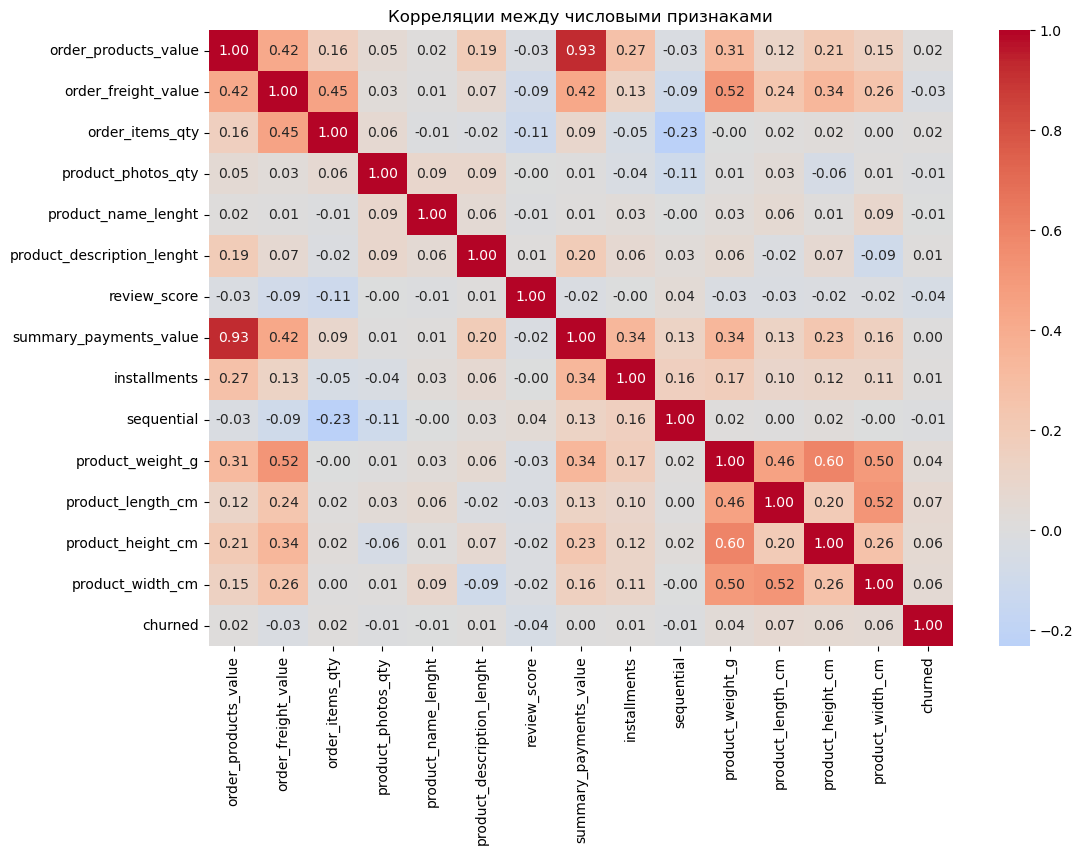

In [126]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции между числовыми признаками")
plt.show()

### Кодирование категориальных признаков 

Мы однозначно кодируем state с помощью OneHotEncoder, так как в нем немного разных категорий. city-признаки содержат более 5000 категорий, поэтому one-hot не подойдет. То же можно сказать и для product_category_name_english на 71 категорию. Попробуем разные подходы кодирования, проверим прирост метрики, зафиксируем и решим оставлять эти признаки или нет.

In [127]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [136]:
X_te = pd.Series(index=X.index, dtype=float)   # сюда сложим out-of-fold TE
global_mean = y.mean()                         # μ в формуле сглаживания
alpha = 10                                     # сглаживание; подбирается
col = ['customer_city', 'seller_city', 'product_category_name_english']

In [139]:
for tr_idx, val_idx in skf.split(X, y):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_val = X.iloc[val_idx]

    # ① склеиваем признак и target
    tmp = X_tr[col].copy()
    tmp['target'] = y_tr.values

    # ② считаем сумму и счётчик
    stats = (tmp
             .groupby(col)
             .agg(sum_target=('target','sum'),
                  cnt=('target','count'))
             .reset_index())

    # ③ рассчитываем TE со сглаживанием
    stats['te'] = (stats['sum_target'] + alpha*global_mean) / (stats['cnt'] + alpha)
    mapping = stats.set_index(col)['te']

    # ④ применяем к валидационной части
    X_te.iloc[val_idx] = X_val[col].map(mapping).fillna(global_mean)

TypeError: the first argument must be callable

In [ ]:

# добавляем признак к исходным данным
X_model = X.copy()
X_model[col + '_te'] = X_te
X_model.drop(columns=[col], inplace=True)

In [41]:
print(df['order_id'].value_counts().head())

order_id
0000f01da58c553799200eb71eb0563b    1
00010242fe8c5a6d1ba2dd792cb16214    1
00026c8a4fe2c14efa2afe807921981c    1
000312d02b605a8a630c3a9882793ffb    1
000330af600103828257923c9aa98ae2    1
Name: count, dtype: Int64


In [42]:
print(df['customer_id'].value_counts().head())

customer_id
aaf96a43700cc28f3d1f6115e9bf311e    1
3ce436f183e68e07877b285a838db11a    1
a7785a0278913274fddadfb4010eb59e    1
d54487c6cb43a7ae702eac4adc1d9224    1
fad0bbc7d520cbb3c5b67d4d4b546826    1
Name: count, dtype: Int64


In [43]:
print(df['product_id'].value_counts().head())

product_id
99a4788cb24856965c36a24e339b6058    606
aca2eb7d00ea1a7b8ebd4e68314663af    601
422879e10f46682990de24d770e7f83d    453
d1c427060a0f73f6b889a5c7c61f2ac4    430
53b36df67ebb7c41585e8d54d6772e08    421
Name: count, dtype: Int64


In [44]:
print(df['review_id'].value_counts().head())

review_id
0000f01da58c553799200eb71eb0563b    1
00010242fe8c5a6d1ba2dd792cb16214    1
00026c8a4fe2c14efa2afe807921981c    1
000312d02b605a8a630c3a9882793ffb    1
000330af600103828257923c9aa98ae2    1
Name: count, dtype: Int64


In [45]:
print(df['customer_unique_id'].value_counts().head())

customer_unique_id
ff4ea78481e00334563aea6d1681f496    10
b6169cb608e0a9d1b0ed53b93fe21713     9
915f2fe0968adc3e5a76d70ca9326bf5     9
779ab1cce17159b31d6a0a4694644455     8
876c06b735eded4e35e1975200afd3aa     7
Name: count, dtype: Int64


In [46]:
print(df['seller_id'].value_counts().head())

seller_id
6560211a19b47992c3666cc44a7e94c0    2710
4a3ca9315b744ce9f8e9374361493884    2430
cc419e0650a3c5ba77189a1882b7556a    2234
1f50f920176fa81dab994f9023523100    1915
da8622b14eb17ae2831f4ac5b9dab84a    1859
Name: count, dtype: Int64


In [48]:
display(df.head())

,order_id,order_products_value,order_freight_value,order_items_qty,product_photos_qty,product_name_lenght,product_description_lenght,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_city,customer_state,customer_zip_code_prefix,product_id,review_id,review_score,product_category_name_english,value,installments,sequential,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,seller_id,seller_zip_code_prefix,seller_city,seller_state,churned
0,0000f01da58c553799200eb71eb0563b,54.900002,18.000000,1,3,58.0,1146.0,2018-01-17,2018-01-18 11:25:59,2017-12-20 16:02:06,2017-12-22 02:38:38.513998,2018-01-16,2018-01-16 22:28:47.059813,aaf96a43700cc28f3d1f6115e9bf311e,sao_jose_dos_campos,sp,122,d363e421b1d15376b299089946fed127,0000f01da58c553799200eb71eb0563b,3,furniture_living_room,72.900002,1,1,3200.0,30.0,11.0,30.0,366d0f35dec4298dce6b76abb9b214ec,870d0118f7a9d85960f29ad89d5d989a,377,pocos_de_caldas,mg,1
1,00010242fe8c5a6d1ba2dd792cb16214,58.900002,13.290000,1,4,58.0,627.0,2017-09-21,2017-09-22 13:57:03,2017-09-13 08:59:02,2017-09-13 09:45:35.019805,2017-09-29,2017-09-20 23:43:48.274761,3ce436f183e68e07877b285a838db11a,campos_dos_goytacazes,rj,280,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,5,cool_stuff,72.190002,2,1,550.0,25.0,7.0,11.0,d71416e1848ae3efa978c0bea9704733,48436dade18ac8b2bce089ec2a041202,272,volta_redonda_1,sp,1
2,00026c8a4fe2c14efa2afe807921981c,389.980011,87.300003,2,4,47.0,417.0,2018-08-05,2018-08-05 15:07:49,2018-07-20 04:39:11,2018-07-21 03:15:19.821915,2018-08-20,2018-08-04 00:16:50.549625,a7785a0278913274fddadfb4010eb59e,lagoa_grande_1,pe,563,9bf49e13f79afe62919c79d125d81cf8,00026c8a4fe2c14efa2afe807921981c,5,garden_tools,477.279999,1,1,1150.0,22.0,21.0,16.0,ee54aa475334c71b07ab5a1055699f38,dfc5fb7259bb2b599ca565e6e9448f0f,097,sao_bernardo_do_campo,sp,0
3,000312d02b605a8a630c3a9882793ffb,600.000000,73.199997,4,10,60.0,1632.0,2017-09-30,2017-10-03 01:41:10,2017-09-19 12:16:14,2017-09-19 12:30:10.302973,2017-10-10,2017-09-29 19:12:27.606354,d54487c6cb43a7ae702eac4adc1d9224,piuma,es,292,588ea3decc0d8e1d19ce6160c5b0da1b,000312d02b605a8a630c3a9882793ffb,5,housewares,673.200012,10,1,1350.0,43.0,18.0,18.0,fb7ac054945d4ead94959436e74aadca,955fee9216a65b617aa5c0531780ce60,047,sao_paulo,sp,1
4,000330af600103828257923c9aa98ae2,59.489998,33.700001,2,7,49.0,1429.0,2017-12-10,2017-12-15 02:58:44,2017-11-13 22:59:54,2017-11-13 23:10:40.663223,2017-12-13,2017-12-09 16:42:14.232409,fad0bbc7d520cbb3c5b67d4d4b546826,barra_de_sao_joao,rj,288,8dacd980e54f23aaaa6bb4f33478664e,000330af600103828257923c9aa98ae2,4,housewares,0.000000,0,0,1600.0,30.0,30.0,30.0,225bffd033b6dae803fc04f6e83751fc,53e4c6e0f4312d4d2107a8c9cddf45cd,139,pedreira,sp,1


In [ ]:
diffs = FeatureUnion([
    ('payment_lag', DateDiffTransformer('order_purchase_timestamp',
                                        'order_aproved_at',
                                        'payment_lag_hours')),
    ('estimated_shipping_lag', DateDiffTransformer('order_aproved_at',
                                         'order_estimated_delivery_date',
                                         'estimated_shipping_lag_hours')),
    ('actual_and_estimated_shipping_lag', DateDiffTransformer('order_estimated_delivery_date',
                                         'order_delivered_customer_date',
                                         'actual_and_estimated_shipping_lag_hours')),
    ('customer_review_response_lag', DateDiffTransformer('review_creation_date',
                                         'review_answer_timestamp',
                                         'customer_review_response_lag_hours')),
    ('approval_and_arrival_lag', DateDiffTransformer('order_aproved_at',
                                         'order_delivered_customer_date',
                                         'approval_and_arrival_lag_hours')),
])